In [1]:
#https://www.youtube.com/watch?v=QIUxPv5PJOY&t=2317s&ab_channel=ComputerScience
import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN

import matplotlib.pyplot as plt
import matplotlib.dates
plt.style.use('fivethirtyeight')

import seaborn as sns

from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from scikeras.wrappers import KerasRegressor

from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#Ucitavanja csv-a i stavljanje da je date kolona index kolona
df = pd.read_csv("TSLA.csv");

#Provera da li ijedna kolona ima null vrednosti
#df.isnull().sum()
#df = df.dropna()

#Konvertovanje podataka kolone Date u Date format
df['Date'] = pd.to_datetime(df.Date)
df

# High = maximalno cena u datom periodu odnosno u danu
# Low = minimalna cena u datom periodu odnosno u danu
# Open = na kojoj ceni je stock poceo na pocetku dana
# Close = na kojoj ceni je stock zavrsion na kraju dana
# Volumen = kolicina koliko je prosla kroz berzu
# Adj Close = podesena cena nakon uracunavanja bilo kakvih korporativnih akcija ( velika kupovina ili tako nesto)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-07-05,6.162000,6.334000,6.160000,6.246000,6.246000,6269000
1,2012-07-06,6.198000,6.346000,6.160000,6.198000,6.198000,3922500
2,2012-07-09,6.188000,6.366000,6.134000,6.298000,6.298000,4552500
3,2012-07-10,6.308000,6.496000,6.178000,6.254000,6.254000,3792000
4,2012-07-11,6.314000,6.336000,6.202000,6.302000,6.302000,3193000
...,...,...,...,...,...,...,...
2510,2022-06-27,748.099976,756.210022,727.700012,734.760010,734.760010,29726100
2511,2022-06-28,733.450012,749.909973,697.030029,697.989990,697.989990,30130400
2512,2022-06-29,691.500000,693.520020,666.820007,685.469971,685.469971,27632400
2513,2022-06-30,673.530029,688.369995,656.590027,673.419983,673.419983,31533500


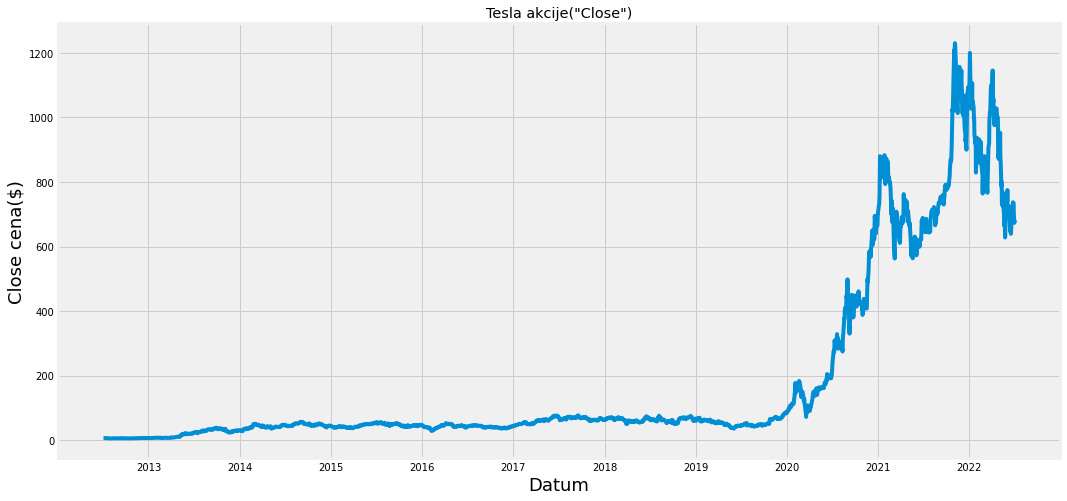

In [3]:
import matplotlib.dates as mdates
#Vizualizacija Close cene akcija

plt.figure(figsize=(16,8))
ax = plt.gca()

#Za formatiranje date kolone da pisu samo godine a ne svaki dan
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

plt.title('Tesla akcije("Close")')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close cena($)', fontsize=18)   

plt.plot(df['Date'], df['Close'])
plt.show()

In [4]:
#Skaliranje podataka
def scale_data(dataset, scaler):
    return scaler.fit_transform(dataset), scaler

#Inverse skaliranje
def inverse_scale(dataset, scaler):
    return scaler.inverse_transform(dataset)

#Podela podataka na train i test skup
def train_test_split(dataset, split=0.8):
    
    #Broj podataka koji ce biti iskorisceni za treniranje
    training_data_len = math.ceil( len(dataset) * split )
    
    print("Ukupan broj podataka: " + str(len(dataset)))
    print("Train broj podataka: " + str(training_data_len))
    print("Test broj podataka: " + str(len(dataset) - training_data_len))
    
    #Kreira training set podataka
    train_data = dataset[0:training_data_len , :]

    x_train = []
    y_train = []

    #Svakih 60 se stavlja u train a 61. se stavlja u train
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i,0])
    #     if i<= 61:
    #         print(x_train)
    #         print(y_train)
    #         print()


    #Konvertuje podatke u nparray
    x_train, y_train = np.array(x_train), np.array(y_train)

    #Reshape podataka
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    #Kreira test set podataka
    test_data = dataset[training_data_len - 60 : , :]

    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])


    #Konvertuje podatke u nparray
    x_test = np.array(x_test)
    #Reshape podataka
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_train, y_train, x_test, y_test, training_data_len

In [5]:
#PREDPROCESIRANJE PODATAKA

#Ucitavanje podatak i konverzija Date kolone u datetime tip
df = pd.read_csv("TSLA.csv");
df['Date'] = pd.to_datetime(df.Date)

#Kreira novi dataframe samo sa 'Close' kolonom
data = df.filter(['Close'])

#Konvertira podateke u nparray
dataset = data.values

#Scaler inicijalizacija
scaler = MinMaxScaler(feature_range=(0,1))

#Skaliraj podatke kolone 'Close'
scaled_data, scaler = scale_data(dataset, scaler)

#Train, test split podataka
x_train, y_train, x_test, y_test, training_data_len= train_test_split(scaled_data, split=0.8)

Ukupan broj podataka: 2515
Train broj podataka: 2012
Test broj podataka: 503


In [6]:
from random import randrange

# Splituje podatke na test i train odmerom split=0.7 ako se ne navede drugacije
def train_test_split_random(dataset, data_size,split=0.7):

    train_size_counter = 0
    indices = []
    train = pd.DataFrame()
    train_size = split * data_size
    dataframe_copy = dataset
    while train_size_counter < train_size:
        train_size_counter = train_size_counter + 1
        index = randrange(data_size)

        while(check_if_element_in_list(index, indices)):
            index = randrange(data_size)

        indices.append(index)

    for i in range(len(indices)+1):
        train = train.append(dataframe_copy.iloc[[i]])

    dataframe_copy = dataframe_copy.drop(labels = indices, axis=0)
    dataframe_copy = dataframe_copy.reset_index(drop=True)

    return train, dataframe_copy

def check_if_element_in_list(x, lista):
    if x in lista:
        return True
    else:
        return False
    

In [7]:
# #Modeli Linearne regresije
# #######################################
# from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import ElasticNet

# lin_reg_model = LinearRegression()

# df2 = pd.DataFrame(scaled_data)
# y_train, y_test = train_test_split_random(df2, len(df2), split=0.8)
# x_train = pd.DataFrame([i for i in range(0,len(y_train))])
# x_test = pd.DataFrame([i for i in range(len(y_train), len(y_train) + len(y_test))])

# #Obicna Linearna Regresija
# lin_reg_model = LinearRegression()
# lin_reg_model.fit(x_train, y_train)
# lin_reg_result = lin_reg_model.predict(x_test)

# lin_reg_result = inverse_scale(lin_reg_result, scaler)
# print(math.sqrt(mean_squared_error(y_test, lin_reg_result)))


# #Lasso regresija
# lasso_reg_model = Lasso(alpha=1)
# lasso_reg_model.fit(x_train, y_train)
# lasso_reg_result = bay_reg_model.predict(x_test)

# lasso_reg_result = inverse_scale(lasso_reg_result.reshape(-1, 1), scaler)
# print(math.sqrt(mean_squared_error(y_test, lasso_reg_result)))



# #Elastic Net regresija
# el_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
# el_model.fit(x_train, y_train)
# el_reg_result = el_model.predict(x_test)

# el_reg_result = inverse_scale(el_reg_result.reshape(-1, 1), scaler)
# print(math.sqrt(mean_squared_error(y_test, el_reg_result)))

In [8]:
#Postavljanje i testiranje Model1
#######################################
model1 = Sequential()
model1.add(LSTM(55, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model1.add(Dropout(0.2))
model1.add(LSTM(30, return_sequences = False))
model1.add(Dropout(0.2))
#Dodaje dense layere sa 25 i 1 neuronom
model1.add(Dense(10))
model1.add(Dense(1))


#Kompilacija modela
model1.compile(optimizer='adam', loss='mean_squared_error')

#Treniranje modela
model1.fit(x_train, y_train, batch_size=32, epochs=10)

#Sacuvaj istreniran model za ensamble(.hdf5 - ekstenzija da celu mrezu sacuva u jedan fajl)
model1.save('saved_models/model1.hdf5')


#Predvidja cenu na osnovu test skupa
predictions1 = model1.predict(x_test)
predictions1 = inverse_scale(predictions1, scaler)
# predictions = scaler.inverse_transform(predictions)

#RMSE
print(math.sqrt(mean_squared_error(y_test, predictions1)))

Epoch 1/10
61/61 [==============================] - 5s 36ms/step - loss: 3.5216e-04
Epoch 2/10
61/61 [==============================] - 2s 35ms/step - loss: 4.5537e-05
Epoch 3/10
61/61 [==============================] - 2s 35ms/step - loss: 5.7631e-05
Epoch 4/10
61/61 [==============================] - 2s 35ms/step - loss: 3.9844e-05
Epoch 5/10
61/61 [==============================] - 2s 35ms/step - loss: 3.5914e-05
Epoch 6/10
61/61 [==============================] - 2s 35ms/step - loss: 3.7392e-05
Epoch 7/10
61/61 [==============================] - 2s 35ms/step - loss: 3.6255e-05
Epoch 8/10
61/61 [==============================] - 2s 35ms/step - loss: 3.2400e-05
Epoch 9/10
61/61 [==============================] - 2s 35ms/step - loss: 2.6363e-05
Epoch 10/10
16/16 [==============================] - 1s 17ms/step
829.9221828646745


In [ ]:
#Postavljanje i testiranje Model2
#######################################
model2 = Sequential()
model2.add(GRU(65, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model2.add(Dropout(0.2))
model2.add(GRU(55, return_sequences = True))
model2.add(Dropout(0.2))
model2.add(GRU(25))
model2.add(Dense(1))

#Kompilacija modela
model2.compile(optimizer='adam', loss='mean_squared_error')

#Treniranje modela
model2.fit(x_train, y_train, batch_size=32, epochs=10)

#Sacuvaj istreniran model za ensamble
model2.save('saved_models/model2.hdf5')


#Predvidja cenu na osnovu test skupa
predictions2 = model2.predict(x_test)
predictions2 = inverse_scale(predictions2, scaler)

#RMSE
print(math.sqrt(mean_squared_error(y_test, predictions2)))

Epoch 1/10
61/61 [==============================] - 7s 51ms/step - loss: 1.3513e-04
Epoch 2/10
61/61 [==============================] - 3s 51ms/step - loss: 2.2785e-05
Epoch 3/10
61/61 [==============================] - 3s 51ms/step - loss: 2.2948e-05
Epoch 4/10
61/61 [==============================] - 3s 51ms/step - loss: 1.9132e-05
Epoch 5/10
61/61 [==============================] - 3s 51ms/step - loss: 2.2303e-05
Epoch 6/10
61/61 [==============================] - 3s 50ms/step - loss: 2.3114e-05
Epoch 7/10
61/61 [==============================] - 3s 50ms/step - loss: 1.8563e-05
Epoch 8/10
61/61 [==============================] - 3s 50ms/step - loss: 1.8745e-05
Epoch 9/10
61/61 [==============================] - 3s 50ms/step - loss: 2.0380e-05
Epoch 10/10
38/61 [=================>............] - ETA: 1s - loss: 1.8932e-05

In [ ]:
#Postavljanje i testiranje Model3
#######################################
model3 = Sequential()
# model3.add(SimpleRNN(70, return_sequences=True, input_shape=(x_train.shape[1], 1)))
# model3.add(SimpleRNN(55, return_sequences=True))
# model3.add(SimpleRNN(35))
# model3.add(Dense(20))
# model3.add(Dense(1))

model3.add(SimpleRNN(55, input_shape=(x_train.shape[1], 1), activation="relu", return_sequences=True,))
model3.add(Dropout(0.2))
model3.add(SimpleRNN(25, activation="relu"))
model3.add(Dense(10, activation="relu")) 
model3.add(Dense(1))


#Kompilacija modela
model3.compile(optimizer='adam', loss='mean_squared_error')

#Treniranje modela
model3.fit(x_train, y_train, batch_size=32, epochs=10)

#Sacuvaj istreniran model za ensamble
model3.save('saved_models/model3.hdf5')


#Predvidja cenu na osnovu test skupa
predictions3 = model3.predict(x_test)
predictions3 = inverse_scale(predictions3, scaler)
# predictions = scaler.inverse_transform(predictions)

#RMSE
print(math.sqrt(mean_squared_error(y_test, predictions3)))

In [ ]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

# model1 = load_model('saved_models/model1.hdf5')
# model2 = load_model('saved_models/model2.hdf5')
# model3 = load_model('saved_models/model3.hdf5')

#Predikcije modela
prediction1 = model1.predict(x_test)
prediction2 = model2.predict(x_test)
prediction3 = model3.predict(x_test)

prediction1 = inverse_scale(prediction1, scaler)
prediction2 = inverse_scale(prediction2, scaler)
prediction3 = inverse_scale(prediction3, scaler)

# from sklearn.metrics import mean_absolute_percentage_error
# mape1 = mean_absolute_percentage_error(y_test, prediction1)
# mape2 = mean_absolute_percentage_error(y_test, prediction2)
# mape3 = mean_absolute_percentage_error(y_test, prediction3)


# rmse_model1 = np.sqrt( np.mean(prediction1 - y_test) **2)
# rmse_model2 = np.sqrt( np.mean(prediction2 - y_test) **2)
# rmse_model3 = np.sqrt( np.mean(prediction3 - y_test) **2)


rmse_model1 = math.sqrt(mean_squared_error(y_test, prediction1))
rmse_model2 = math.sqrt(mean_squared_error(y_test, prediction2))
rmse_model3 = math.sqrt(mean_squared_error(y_test, prediction3))


#RUNCO DOBIJANJE MEANA SA WEIGHTS
#################################################
# models = [model1, model2, model3]
# preds = [model.predict(x_test) for model in models]
# preds=np.array(preds)

# for idx, x in enumerate(preds):
#     preds[idx] = inverse_scale(preds[idx], scaler)
    
# weights = [0.8, 0.3, 0.2]

# #Sabira resenja sve tri liste i pomnozi ih sa weightsom
# weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))

# weight_sum = 0;
# for i in weights:
#     weight_sum += i
    
# #Podeli sa brojem modela svaku kolonu da se dobije mean
# weighted_preds = [element/weight_sum for element in weighted_preds] #len(models)
#################################################

#weighted_accuracy = np.sqrt( np.mean(weighted_preds - y_test) **2)


#Pregled preciznosti modela 1,2,3
print('Model1, rmse = '+ str(rmse_model1)) # + ", mape = " + str(mape1) + ", real_rmse = " + str(rmse1))
print('Model2, rmse = '+ str(rmse_model2)) # + ", mape = " + str(mape2) + ", real_rmse = " + str(rmse2))
print('Model3, rmse = '+ str(rmse_model3)) # + ", mape = " + str(mape3) + ", real_rmse = " + str(rmse3))

In [ ]:
# model1 = load_model('saved_models/model1.hdf5')
# model2 = load_model('saved_models/model2.hdf5')
# model3 = load_model('saved_models/model3.hdf5')
# models = [model1, model2, model3]

def make_model1():
    #Model 1
    model1 = Sequential()
    model1.add(LSTM(55, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model1.add(Dropout(0.2))
    model1.add(LSTM(55, return_sequences = False))
    model1.add(Dropout(0.2))
    #Dodaje dense layere sa 25 i 1 neuronom
    model1.add(Dense(25))
    model1.add(Dense(1))


    #Kompilacija modela
    model1.compile(optimizer='adam', loss='mean_squared_error')
    
    return model1

def make_model2():
    #Model 2
    model2 = Sequential()
    model2.add(GRU(65, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model2.add(Dropout(0.2))
    model2.add(GRU(55, return_sequences = True))
    model2.add(Dropout(0.2))
    model2.add(GRU(25))
    model2.add(Dense(1))

    #Kompilacija modela
    model2.compile(optimizer='adam', loss='mean_squared_error')
    return model2

    
def make_model3():
    #Model 3
    model3 = Sequential()

    model3.add(SimpleRNN(55, input_shape=(x_train.shape[1], 1), activation="relu", return_sequences=True,))
    model3.add(Dropout(0.2))
    model3.add(SimpleRNN(25, activation="relu"))
    model3.add(Dense(10, activation="relu")) 
    model3.add(Dense(1))


    #Kompilacija modela
    model3.compile(optimizer='adam', loss='mean_squared_error')
    return model3



estimator1 = KerasRegressor(model=make_model1, epochs=10, batch_size=32)
estimator2 = KerasRegressor(model=make_model2, epochs=10, batch_size=32)
estimator3 = KerasRegressor(model=make_model3, epochs=10, batch_size=32)


level0 = list()
level0.append(('model1', estimator1))
level0.append(('model2', estimator2))
level0.append(('model3', estimator3))

ensemble = VotingRegressor(estimators=level0)
ensemble.fit(x_train, y_train)

In [ ]:
final_predictions = ensemble.predict(x_test)
final_predictions = final_predictions.reshape((len(final_predictions),1))

final_predictions = inverse_scale(final_predictions, scaler)
    
#ensamble_rmse = np.sqrt( np.mean(final_predictions - y_test) **2)
#ensamble_mse = mean_squared_error(y_test, final_predictions)
ensamble_real_rmse = math.sqrt(mean_squared_error(y_test, final_predictions))

print('Model1, rmse = '+ str(rmse_model1)) # + ", mape = " + str(mape1) + ", real_rmse = " + str(rmse1))
print('Model2, rmse = '+ str(rmse_model2)) # + ", mape = " + str(mape2) + ", real_rmse = " + str(rmse2))
print('Model3, rmse = '+ str(rmse_model3)) # + ", mape = " + str(mape3) + ", real_rmse = " + str(rmse3))
print('Ensamble rmse = ', str(ensamble_real_rmse)) # +  ", real_rmse = " + str(ensamble_rmse))


In [ ]:
#Plot the results
train = data[:training_data_len]
data_date = df.filter(['Date'])
train['Datum'] = data_date[:training_data_len]

valid = data[training_data_len:]
valid['Predictions'] = final_predictions #final_predictions
valid['Datum'] = data_date[training_data_len:]
# train['Datum'] = df['Date']

#Visualize the data
plt.figure(figsize=(16,8))
ax = plt.gca()
#Za formatiranje date kolone da pisu samo godine a ne svaki dan
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

plt.title('Tesla Akcije("Close")')
plt.xlabel('Datum', fontsize=18)
plt.ylabel('Close cena($)', fontsize=18)

plt.plot(train['Datum'], train['Close'])
plt.plot(valid['Datum'], valid[['Close', 'Predictions']])

plt.legend(['Train', 'Test', 'Predictions'], loc='lower right')
plt.show()